In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [55]:
clinical_raw_data = pd.read_csv('./clinical.csv')
RNAseq_raw_data = pd.read_csv('./RNAseq_15000_samples.csv')
CNV_raw_data = pd.read_csv('./cnv_data_all')
clinical_stages_mapper = clinical_raw_data[['case_barcode','case_gdc_id','clinical_stage']]

In [56]:
clean_data = pd.DataFrame(data=[clinical_raw_data['case_barcode'], clinical_raw_data['clinical_stage']]).T
clean_data.head()

,case_barcode,clinical_stage
0,TCGA-2K-A9WE,NaN
1,TCGA-2Z-A9J9,Stage I
2,TCGA-2Z-A9J5,Stage II
3,TCGA-2Z-A9JG,Stage I
4,TCGA-2Z-A9J3,Stage II


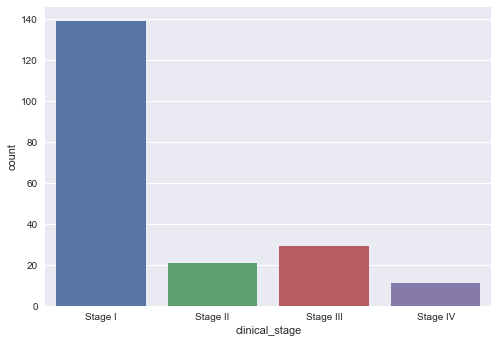

In [57]:
sns.countplot(clean_data['clinical_stage'], order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'])
plt.show()

In [58]:
CNV_raw_stages = CNV_raw_data.merge(clinical_stages_mapper, left_on='case_barcode', right_on='case_barcode')
RNAseq_raw_stages = RNAseq_raw_data.merge(clinical_stages_mapper, left_on='case_barcode', right_on='case_barcode')
indels = CNV_raw_stages[0.2 < abs(CNV_raw_stages['segment_mean'])]
insertions = indels[indels['segment_mean'] > 0]
deletions = indels[indels['segment_mean'] < 0]

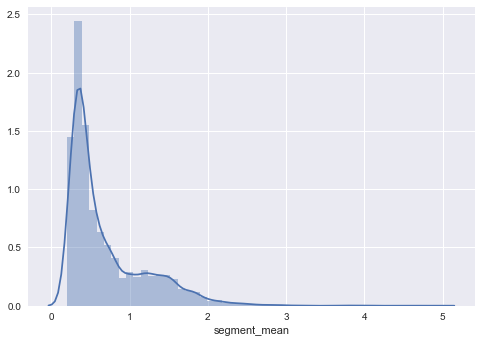

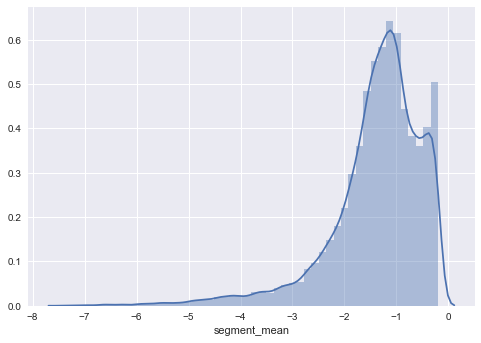

In [59]:
sns.distplot(insertions['segment_mean'])
plt.show()
sns.distplot(deletions['segment_mean'])
plt.show()

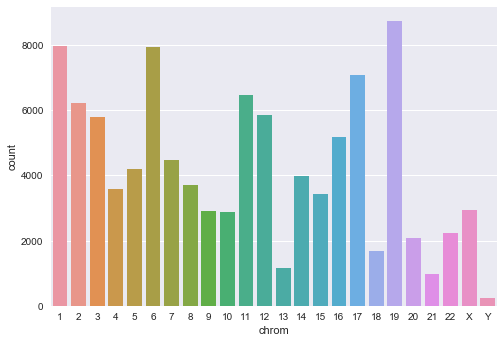

,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,alignID,gene_name
#name,,,,,,,,,,,,
uc061ftb.1,1,-,4611,24650,6126,21127,16,"4611,6990,7816,8603,9364,10139,10910,11706,128...","6370,7102,7989,8655,9537,10191,11083,11758,129...",NaN,ENST00000614336.4,uc061ftb.1
uc061ftc.1,1,-,6100,29626,6126,29453,16,"6100,6990,7816,8603,9364,10139,10910,11706,128...","6370,7102,7989,8655,9537,10191,11083,11758,129...",NaN,ENST00000612640.4,uc061ftc.1
uc061fte.1,1,-,6101,29626,7096,29453,21,"6101,6990,7816,7934,8603,9364,10139,10910,1170...","6370,7102,7930,7989,8655,9537,10191,11083,1175...",NaN,ENST00000616361.1,uc061fte.1
uc061ftd.1,1,-,6100,29626,9513,23107,13,"6100,6990,7816,8603,9364,11706,16870,18226,188...","6370,7102,7989,8655,9537,11758,16922,18432,189...",NaN,ENST00000612721.4,uc061ftd.1
uc032mzo.1,1,+,9554,10601,9554,10601,1,"9554,","10601,",Q8NH00,ENST00000621754.1,uc032mzo.1


In [60]:
import warnings
warnings.simplefilter('ignore')
genes = pd.DataFrame.from_csv('hg19.txt', sep='\t', header=0)
coding_genes = genes[genes['cdsStart'] != genes['cdsEnd']]
coding_genes['chrom'] = coding_genes['chrom'].str.slice(3,5)
coding_genes['chrom'] = coding_genes['chrom'].str.extract('(\d+|[XY])', expand=False)
sns.countplot(coding_genes['chrom'],order=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','X','Y'])
plt.show()
coding_genes.sort_values(['chrom','cdsStart'], inplace=True)
coding_genes['gene_name'] = coding_genes.index
coding_genes = coding_genes[(coding_genes['chrom'].isnull()) != True]
coding_genes.head()

In [61]:
indels['case_barcode'] = pd.factorize(indels.case_barcode)[0]

In [62]:
#index - df
# coding_genes
# 0-chromosome
# 4-cdsStart
# 5-cdsEnd
# 11-gene name
#indels
# 1-case barcode
# 4-chromosome
# 5-start
# 6-end
# 8-segment mean
# 10-case_gdc_id
# 11-clinical_stage
indels_arr = indels.values
coding_genes_arr = coding_genes.values

coding_genes_bychrom = {}
for i in range(0, len(coding_genes_arr)):
    chromosome = coding_genes_arr[i][0]
    if(chromosome in coding_genes_bychrom):
        coding_genes_bychrom[chromosome] = coding_genes_bychrom[chromosome] + [coding_genes_arr[i][0],coding_genes_arr[i][4],coding_genes_arr[i][5],coding_genes_arr[i][11]]
    else:
        coding_genes_bychrom[chromosome] = [coding_genes_arr[i][0],coding_genes_arr[i][4],coding_genes_arr[i][5],coding_genes_arr[i][11]]
    #dict indexed by chromosome [chr, cdsStart, cdsEnd, geneName]

In [63]:
def find_gene(chrom, start, end):
    genes = []
    for i in range(0,len(coding_genes_bychrom[str(chrom)])):
        if(coding_genes_arr[i][4] < start < coding_genes_arr[i][5]):
            genes.append(i)
    return genes
data = np.zeros(shape=(290,len(coding_genes)))
for i in range(0,len(indels_arr)):
    genes = find_gene(indels_arr[i][4], indels_arr[i][5], indels_arr[i][6])
    for gene in genes:
        data[indels_arr[i][1]][gene] = 1

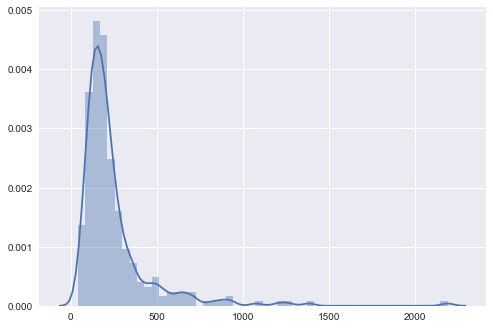

          0
0    1382.0
1     216.0
2     158.0
3     108.0
4     216.0
5     160.0
6     224.0
7     180.0
8     481.0
9     120.0
10    461.0
11    327.0
12     68.0
13    111.0
14    281.0
15    156.0
16    241.0
17    249.0
18    915.0
19    675.0
20    150.0
21    143.0
22    713.0
23    235.0
24    187.0
25    132.0
26    124.0
27    181.0
28    248.0
29    631.0
..      ...
260   131.0
261   140.0
262   143.0
263   205.0
264   223.0
265    86.0
266   173.0
267   274.0
268   153.0
269    83.0
270   199.0
271   268.0
272   155.0
273   202.0
274   302.0
275   163.0
276    65.0
277    64.0
278   122.0
279    69.0
280   140.0
281   258.0
282   116.0
283   154.0
284   134.0
285   183.0
286    75.0
287   200.0
288   180.0
289    90.0

[290 rows x 1 columns]


In [64]:
sns.distplot(data.sum(axis=1))
plt.show()
print(pd.DataFrame(data.sum(axis=1)))